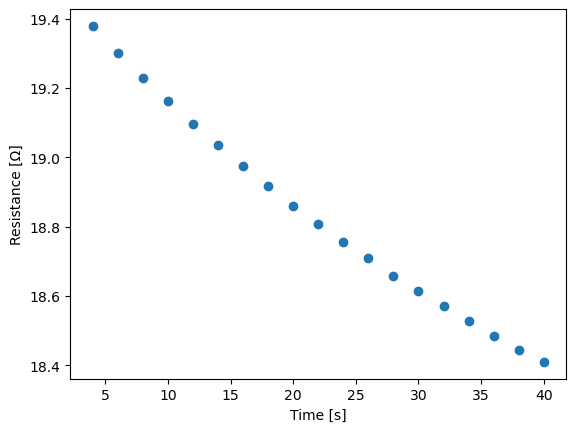

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "Dados/data.csv"
df = pd.read_csv(file_path)

plt.scatter(df['Time'], df['Resistance'])
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.show()

## Estimação por ODR da resistência no instante 0

In [9]:
import numpy as np
from scipy import odr

####### Replicando o artigo de referência #######

# Incertezas de medição:

s_t0 = 1 # Incerteza do tempo inicial

s_dt = 0.001 # Incerteza do tempo de aquisição

s_dR = 0.001 # Incerteza da medição de resistência

# Modelo da função
def estimation_model(params, x):
    return params[1] * x + params[0]

# Prepara dados
x = df['Time'].values
y = df['Resistance'].values

# Passa incerteza para x e y
s_x = np.sqrt(s_t0**2 + s_dt**2)
s_y = s_dR

# Define o modelo
model = odr.Model(estimation_model)

# Create objeto RealData
data = odr.RealData(x, y, sx = s_x, sy = s_y)

# Seta parâmetro iniciais
initial_params = [1.0, 1.0]

# ODR fit
odr_fit = odr.ODR(data, model, beta0=initial_params)
result = odr_fit.run()

# Fitted parameters
intercept, slope = result.beta

# Desvio padrão dos parâmetros estimados
uncertainty = result.sd_beta

print("Uncertainty:", uncertainty)
print("Slope:", slope)
print("Intercept:", intercept)

R2 = intercept
s_R2 = uncertainty[1]

Uncertainty: [0.01533717 0.00062462]
Slope: -0.026891448615093027
Intercept: 19.43066455444976


## Conversão da resistência para temperatura

In [10]:
R1 = 15.39 # Resistência no início do teste
Tamb_1 = 24 # Temperatura ambiente no início do teste
Tamb_2 = 24 # Temperatura ambiente no início do teste

k = 234.5 # Recíproco do coeficiente de temperatura do resistor
alpha = 1/(k+Tamb_1) # Coeficiente de temperatura do resistor

s_R1 = 0.01 # Incerteza da medição de resistência no início do teste
s_Tamb1 = 0.1 # Incerteza da medição de temperatura no início do teste
s_Tamb2 = 0.1 # Incerteza da medição de temperatura no final do teste


# Usando equação do artigo IEEE LATAM

# Cálculo da variação de temperatura 
def T2_LATAM(R2):
    return (R2-R1)/(R1*alpha) + Tamb_1

dT1 = T2_LATAM(R2) - Tamb_1

def uncertainty_LATAM(R2,s_R2):
    s_dT = [1*s_Tamb1, # Incerteza da temperatura ambiente
            -R2/(alpha*(R1**2))*s_R1, # Incerteza da resistência inicial
            1/(alpha*R1)*s_R2] # Incerteza da resistência final

    return np.linalg.norm(s_dT) # Incerteza combinada é a raiz da soma dos quadrados

s_dT1 = uncertainty_LATAM(R2,s_R2)

print("IEEE LATAM")
print("Temperature rise [K]:", dT1)
print("Uncertainty [K]:", s_dT1)
print('\n')

# Usando equação do artigo do Int J Thermophys, com correção
# na ordem de R1 e R2

# Cálculo da variação de temperatura 
def T2_TERMOP(R2):
    return (R2-R1)/R1*(k+Tamb_1)-(Tamb_2-Tamb_1)
dT2 = T2_TERMOP(R2)-Tamb_1

def uncertainty_TERMOP(R2,s_R2):
    s_dT = [((R2-R1)/R1 + 1)*s_Tamb1, # Incerteza da temperatura ambiente inicial
         -1*s_Tamb2, # Incerteza da temperatura ambiente final
         -R2*(k+Tamb_1)/(R1**2)*s_R1, # Incerteza da resistência inicial
         (k+Tamb_1)/R1*s_R2] # Incerteza da resistência final
    
    return np.linalg.norm(s_dT) # Incerteza combinada é a raiz da soma dos quadrados

s_dT2 = uncertainty_TERMOP(R2,s_R2)

print("Int J Thermophys")
print("Temperature rise [K]:", dT2)
print("Uncertainty [K]:", s_dT2)

IEEE LATAM
Temperature rise [K]: 67.86951184699562
Uncertainty [K]: 0.23469564148043154


Int J Thermophys
Temperature rise [K]: 43.86951184699562
Uncertainty [K]: 0.26650028528892983


### Estimação de modelo exponencial usando função própria

Resistance at t0: 19.530338942889678
Uncertainty for t0: 0.047204121854854356
Estimated temperature at t0: 93.54370479122687
Uncertainty for estimated temperature at t0: 0.8270894689124962
f(x) =  17.46111995188792 + 2.0692189910017587 exp( -0.01951516792135787 x)
SSE: 0.06148431102933262
Beta: [17.46111995  2.06921899 -0.01951517]
Beta Std Error: [0.018118   0.01641121 0.0002673 ]
Beta Covariance: [[ 8.54232809e-02 -7.71369435e-02 -1.25457970e-03]
 [-7.71369435e-02  7.00868877e-02  1.12526686e-03]
 [-1.25457970e-03  1.12526686e-03  1.85928640e-05]]
Residual Variance: 0.0038427694393332883
Inverse Condition #: 0.0006477098735972695
Reason(s) for Halting:
  Sum of squares convergence


y:\Metrology_IncertezaTemperatura\fcn.py:40: RuntimeWarning: overflow encountered in exp
  return params[0] + params[1] * np.exp(params[2] * x)


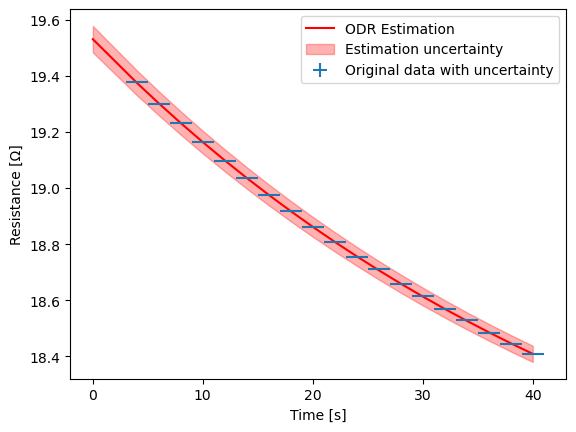

In [11]:
from fcn import estimate_model_with_uncertainty

# Estimando o modelo exponencial com incerteza

params, uncertainty, result = estimate_model_with_uncertainty(x, y, s_x, s_y, model='exp', initial_params= [20,1,-1],maxit = 10000)

R2 = params[0] + params[1]

def uncertainty_exp(x):
        s_R2 = [1*uncertainty[0], # Incerteza do parâmetro 0
                np.exp(params[2]*x)*uncertainty[1], # Incerteza do parâmetro 1
                x*params[1]*np.exp(params[2]*x)*uncertainty[2], # Incerteza do parâmetro 2
                params[1]*params[2]*np.exp(params[2]*x)*s_x, # Incerteza de x (t0)
                ]
        return np.linalg.norm(s_R2) # Incerteza combinada é a raiz da soma dos quadrados

# Incerteza p/ x = 0:
x_s = 0
s_R2 = uncertainty_exp(x_s)

print("Resistance at t0:", R2)
print("Uncertainty for t0:", s_R2)
print("Estimated temperature at t0:", T2_LATAM(R2))
print("Uncertainty for estimated temperature at t0:", uncertainty_LATAM(R2,s_R2))
print("f(x) = ", params[0], '+', params[1], 'exp(', params[2], 'x)')
print("SSE:", result.sum_square)
result.pprint()

def exp_model(params, x):
            return params[0] + params[1] * np.exp(params[2] * x)

x_plot = np.insert(x, 0, 0)
s_R= [uncertainty_exp(xx) for xx in x_plot]
plt.plot(x_plot, exp_model(params, x_plot), color='red', label='ODR Estimation')
plt.fill_between(x_plot, exp_model(params, x_plot) - s_R, exp_model(params, x_plot) + s_R, color='red', alpha=0.3, label='Estimation uncertainty')
plt.errorbar(x, y, yerr=s_y, xerr=s_x, fmt='none', label='Original data with uncertainty')
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.legend()
plt.show()

Resistance at t0: 19.43066455444976
Uncertainty for t0: 0.030957706373523453
Estimated temperature at t0: 91.86951184699562
Uncertainty for estimated temperature at t0: 0.5704000637794769
f(x) =  19.43066455444976 + -0.026891448615093027 x
SSE: 20.693568677575097
Beta: [19.43066455 -0.02689145]
Beta Std Error: [0.01533717 0.00062462]
Beta Covariance: [[ 1.93243154e-04 -7.05136036e-06]
 [-7.05136036e-06  3.20516279e-07]]
Residual Variance: 1.2172687457397118
Inverse Condition #: 0.017749020486203453
Reason(s) for Halting:
  Sum of squares convergence


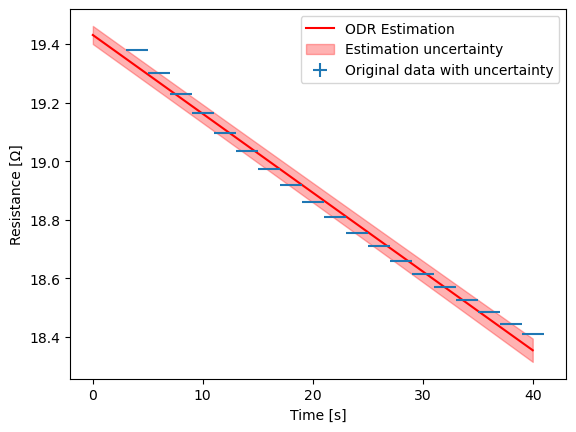

In [12]:
# Estimando o modelo linear com incerteza

params, uncertainty, result = estimate_model_with_uncertainty(x, y, s_x, s_y, model='lin', maxit = 10000)

R2 = params[0]

def lin_model(params, x):
    return params[0] + params[1] * x

def uncertainty_lin(x):
        s_R2 = [1*uncertainty[0], # Incerteza do parâmetro 0
                x*uncertainty[1], # Incerteza do parâmetro 1
                params[1]*s_x, # Incerteza de x (t0)
                ]
        return np.linalg.norm(s_R2) # Incerteza combinada é a raiz da soma dos quadrados

# Incerteza p/ x = 0:
x_s = 0
s_R2 = uncertainty_lin(x_s)

print("Resistance at t0:", R2)
print("Uncertainty for t0:", s_R2)
print("Estimated temperature at t0:", T2_LATAM(R2))
print("Uncertainty for estimated temperature at t0:", uncertainty_LATAM(R2,s_R2))
print("f(x) = ", params[0], '+', params[1], 'x')
print("SSE:", result.sum_square)
result.pprint()

x_plot = np.insert(x, 0, 0)
s_R= [uncertainty_lin(xx) for xx in x_plot]
plt.plot(x_plot, lin_model(params, x_plot), color='red', label='ODR Estimation')
plt.fill_between(x_plot, lin_model(params, x_plot) - s_R, lin_model(params, x_plot) + s_R, color='red', alpha=0.3, label='Estimation uncertainty')
plt.errorbar(x, y, yerr=s_y, xerr=s_x, fmt='none', label='Original data with uncertainty')
plt.xlabel('Time [s]')
plt.ylabel('Resistance [Ω]')
plt.legend()
plt.show()

In [16]:
import numpy as np

x0 = np.array([69.1,69.3,69.6])
x1 = np.array([66.3,68.3,69.1]) 
x2 = np.array([65.6,68.1,70.0])
x3 = np.array([62.1,65.6,73.3])

s_x0 = np.std(x0)/(2*np.sqrt(3))
s_x1 = np.std(x1)/(2*np.sqrt(3))
s_x2 = np.std(x2)/(2*np.sqrt(3))
s_x3 = np.std(x3)/(2*np.sqrt(3))

print(np.linalg.norm([s_x0,10e-3,1e-3]))
print(np.linalg.norm([s_x1,10e-3,1e-3]))
print(np.linalg.norm([s_x2,10e-3,1e-3]))
print(np.linalg.norm([s_x3,10e-3,1e-3]))


0.222
1.2549103466718747
1.919715397528144
4.983549613776826
